In [9]:
!wget https://github.com/xuhuihuang/GME_tutorials/raw/main/tutorials/alanine_dipeptide/MacroGME/TPM.npy
!wget https://github.com/xuhuihuang/GME_tutorials/raw/main/tutorials/alanine_dipeptide/MacroGME/bootstrap_TPM.npy
!wget https://github.com/xuhuihuang/GME_tutorials/raw/main/quasi-MSM/qmsm.py
!wget https://github.com/xuhuihuang/GME_tutorials/raw/main/IGME/igme.py

--2024-08-12 02:06:56--  https://github.com/xuhuihuang/GME_tutorials/raw/main/tutorials/alanine_dipeptide/MacroGME/TPM.npy
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/xuhuihuang/GME_tutorials/main/tutorials/alanine_dipeptide/MacroGME/TPM.npy [following]
--2024-08-12 02:06:57--  https://raw.githubusercontent.com/xuhuihuang/GME_tutorials/main/tutorials/alanine_dipeptide/MacroGME/TPM.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64128 (63K) [application/octet-stream]
Saving to: ‘TPM.npy’

TPM.npy             100%[===================>]  62.62K  --.-KB/s    in 0.01s   

2024-08-12 02:06:57 

In [11]:
# @title Import necessary packages
from igme import IGME
from qmsm import QuasiMSM, MSM
import numpy as np
from matplotlib import pyplot as plt

TPM = np.load("TPM.npy")
bootstrap_TPM = np.load("bootstrap_TPM.npy")

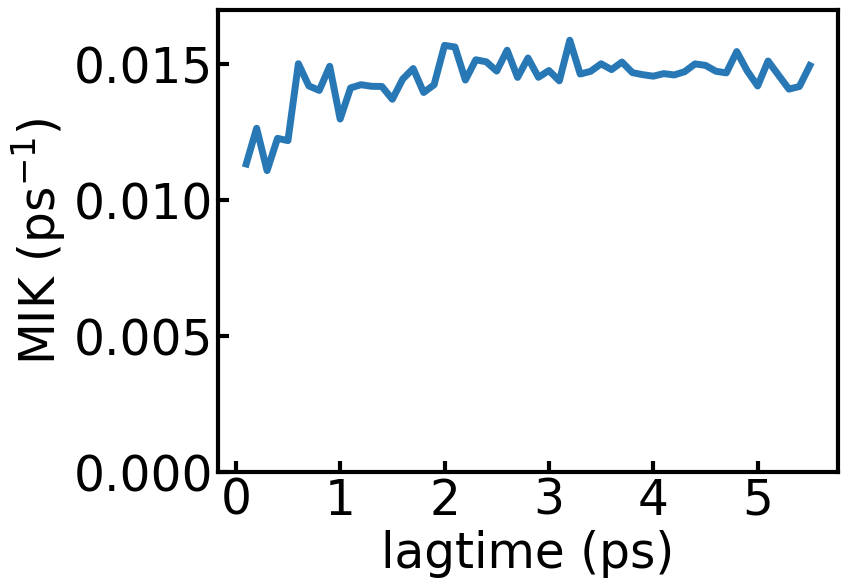

In [13]:
# @title Compute Mean Integeral Kernel (MIK) from qMSM
delta_t = 0.1 # ps

qmsm = QuasiMSM()
lagtime = np.arange(1, 56) * delta_t
qmsm.fit(TPM, tau_k=55, delta_t=delta_t, rmse=False)

# plot MIK
plt.rcParams['font.size'] = 35
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(lagtime, qmsm.mik, color='#2878B5', linewidth=5, label='qMSM', zorder=1)
plt.plot([], [], color='#C82423', linewidth=5, label='IGME', linestyle='--',)
plt.ylim(0, 0.017)
plt.xlabel('lagtime (ps)')
plt.ylabel('MIK (ps$^{-1}$)')
ax.tick_params(axis='both', direction='in', width=3, length=8)
ax.set_xticks(ticks=[0,1,2,3,4,5])
for spine in ax.spines.values():
    spine.set_linewidth(3)
plt.show()

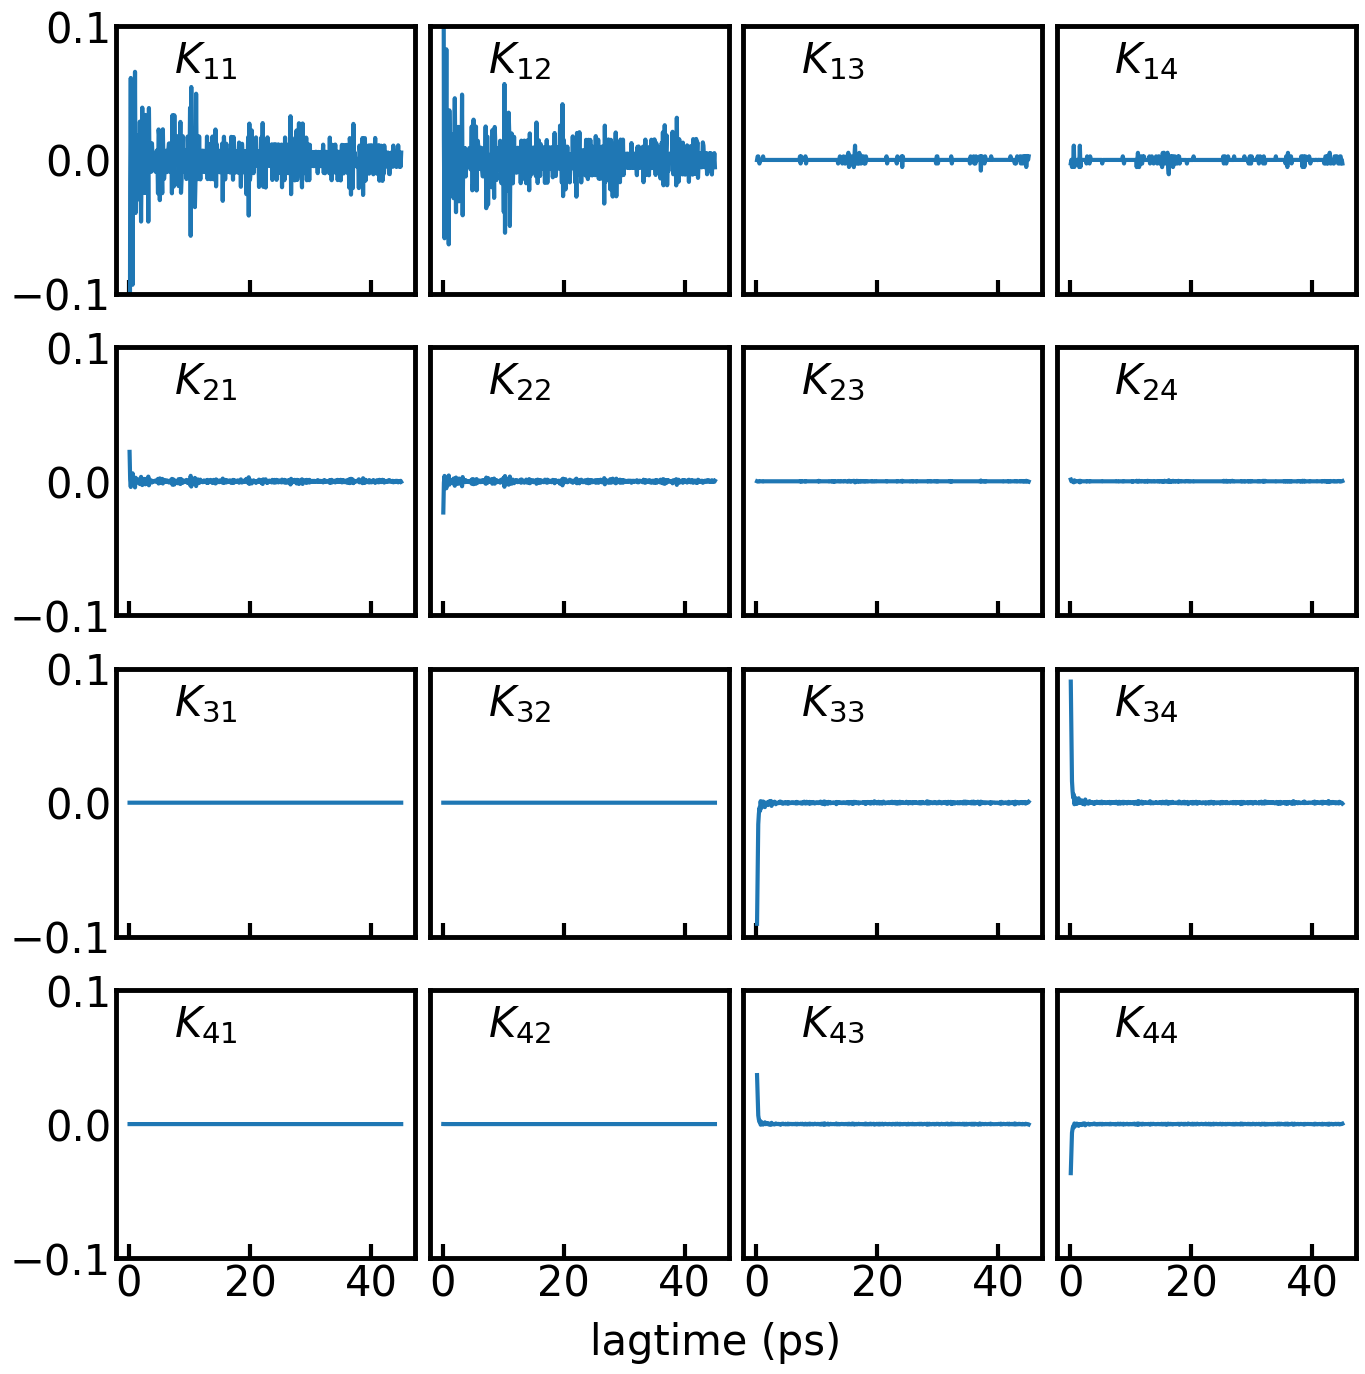

In [14]:
# K(t)
qmsm = QuasiMSM()
qmsm.fit(TPM, tau_k=450, delta_t=0.1, rmse=False)

plt.rcParams['font.size'] = 30
fig, axes = plt.subplots(4,4,figsize=(16,16), sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        ax = axes[i,j]
        ax.plot(np.arange(1, 451, 1)*delta_t, qmsm.K[:,i,j], linewidth=3)
        ax.set_ylim(-0.1,0.1)
        ax.tick_params(axis='x', direction='in', width=3, length=10)
        ax.tick_params(axis='y', direction='in', width=0, length=0)
        ax.set_xticks(ticks=[0,20,40], labels=[0,20,40])
        ax.text(18, 0.09, '$K_{{{}{}}}$'.format(i+1, j+1), ha='right',va='top')
        for spine in ax.spines.values():
            spine.set_linewidth(3.5)
plt.subplots_adjust(wspace=0.05, hspace=0.2)
fig.text(0.5, 0.07, 'lagtime (ps)', ha='center', va='top')
plt.show()

In [15]:
# @title Build qMSM
qmsm = QuasiMSM()
qmsm.fit(TPM, tau_k=15, delta_t=delta_t)
qmsm_time, qmsm_tpm = qmsm.predict(TPM) # Use qMSM for prediction
qmsm_rmse = qmsm.rmse # RMSE list of the qMSM models with tau_k from 1 to 15 (* 0.1 ps)
qmsm_its = qmsm.timescales(TPM, ITS_t=100) # ITS predicted by qMSM

In [16]:
# @title Build IGME

# Scan tau_k and L
igme = IGME()
scan_output = igme.scan(input_data=TPM, begin=1, end=16)

# Build top IGME
igme_top = igme.top_model(scan_output, n=1) # Select the top IGME model
igme_tpm = np.array(igme_top.predict(1,len(TPM))) # Use IGME for prediction
igme_top_rmse = igme_top.rmse # RMSE of the top IGME model
igme_mik = igme_top.mik[1] / delta_t
igme_its = igme_top.timescales * delta_t # ITS predicted by top IGME

In [17]:
# @title Build macrostate-MSM
msm = MSM()
tau = np.arange(1, 101)
msm_rmse = msm.scan(TPM, delta_t=0.1, tau_lst=tau, rmse_weighted_by_sp=True)

# Build 1.5 ps MSM
msm_0 = MSM()
msm_0.fit(TPM, tau=15, delta_t = 0.1, rmse=True)
msm_time_0, msm_tpm_0 = msm_0.predict(end=500, add_iden_mat=True)

# Build 10 ps MSM
msm_1 = MSM()
msm_1.fit(TPM, tau=100, delta_t = 0.1, rmse=True)
msm_time_1, msm_tpm_1 = msm_1.predict(end=500, add_iden_mat=True)

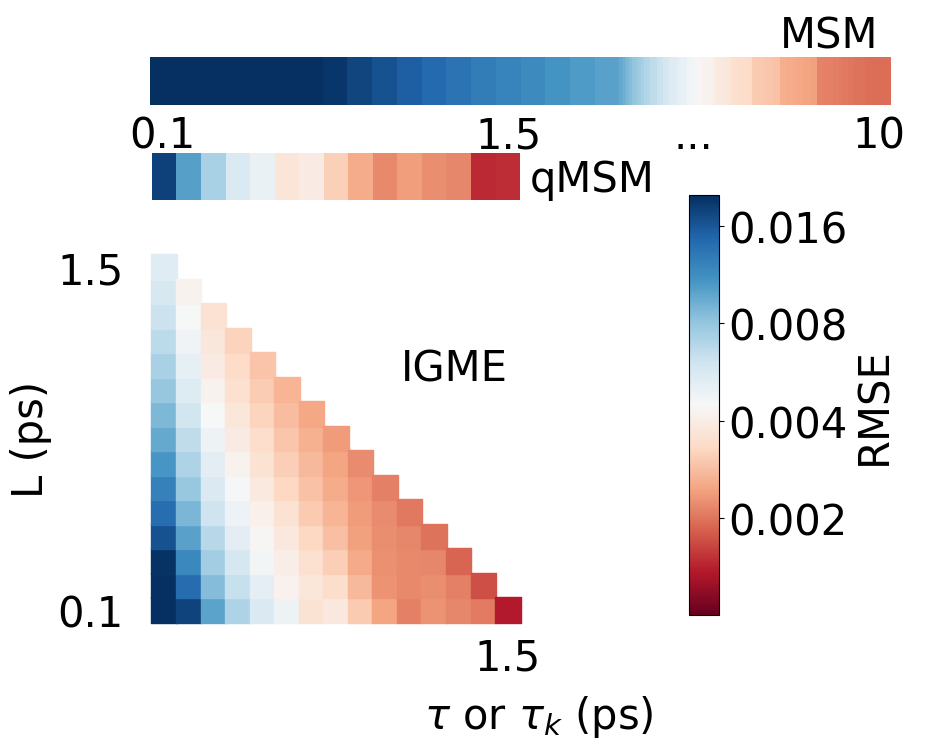

In [18]:
# @title Plot RMSE map

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
x = [i * 0.1 for i in scan_output['begin']]
y = [(scan_output['end'][i] - scan_output['begin'][i]) * 0.1 for i in range(len(x))]
z = scan_output['rmse']

cmap_name = 'RdBu'  # You can use any colormap of your choice from Matplotlib's colormaps
custom_cmap = plt.get_cmap(cmap_name)
norm = mcolors.LogNorm(vmin=1e-3, vmax=2e-2)

def adjust_tau(x):
    if x < 20:
        return x/10
    else:
        return x/80 + 1.75

plt.rcParams['font.size'] = 30
fig, axes = plt.subplots(2, 1, figsize=(6,6), sharex=True,
                         gridspec_kw={'height_ratios': [1, 4]})

lagtime = np.arange(1, 16, 1)
qmsm_color_bar = custom_cmap(norm(qmsm_rmse))
upper_bound = np.ones(len(lagtime))*0.5
axes[0].bar(lagtime*0.1, upper_bound, color=qmsm_color_bar, width=0.1)
axes[0].set_yticks([])
axes[0].set_xticks([])
axes[0].set_ylim(-0.5, 0.5)
axes[0].text(2.1, 0, 'qMSM', ha='right', va='bottom')
axes[0].set_frame_on(False)
axes[0].tick_params(left=False, right=False, bottom=False, top=False)

axes[1].scatter(x, y, c=z, cmap=custom_cmap, norm=norm, marker='s', s=335 )
axes[1].set_frame_on(False)
axes[1].tick_params(left=False, right=False, bottom=False, top=False)
axes[1].set_xticks([1.5])
axes[1].set_yticks([0.1, 1.5])
axes[1].text(1.5, 1, 'IGME', ha='right', va='bottom')
fig.text(0.8, 0, '$\\tau$ or $ \\tau_k $ (ps)', ha='center', va='top')
axes[1].set_ylabel('L (ps)')

plt.subplots_adjust(hspace=0.01)
fig.subplots_adjust(top=0.9)
msm_ax = fig.add_axes([0.09, 0.98, 1.36, 0.16])
upper_bound = np.ones(len(tau))*0.5
msm_color_bar = custom_cmap(norm(msm_rmse))
msm_ax.bar([adjust_tau(i) for i in tau], upper_bound, color=msm_color_bar, width=0.1)
msm_ax.set_yticks([])
msm_ax.set_xticks([])
msm_ax.set_ylim(0, 1)
msm_ax.set_xticks([0.1, 1.5, 2.25, 3], labels=[0.1, 1.5, "...", 10])
msm_ax.text(2.6,0.6,'MSM')
msm_ax.set_frame_on(False)
msm_ax.tick_params(left=False, right=False, bottom=False, top=False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.05, 0.13, 0.05, 0.7])
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=cbar_ax)
# ticks = [1e-2, 2e-2, 4e-2, 8e-2, 1.6e-1]
ticks = [2e-3, 4e-3, 8e-3, 1.6e-2]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
cbar.ax.minorticks_off()
cbar.set_label('RMSE')
plt.show()

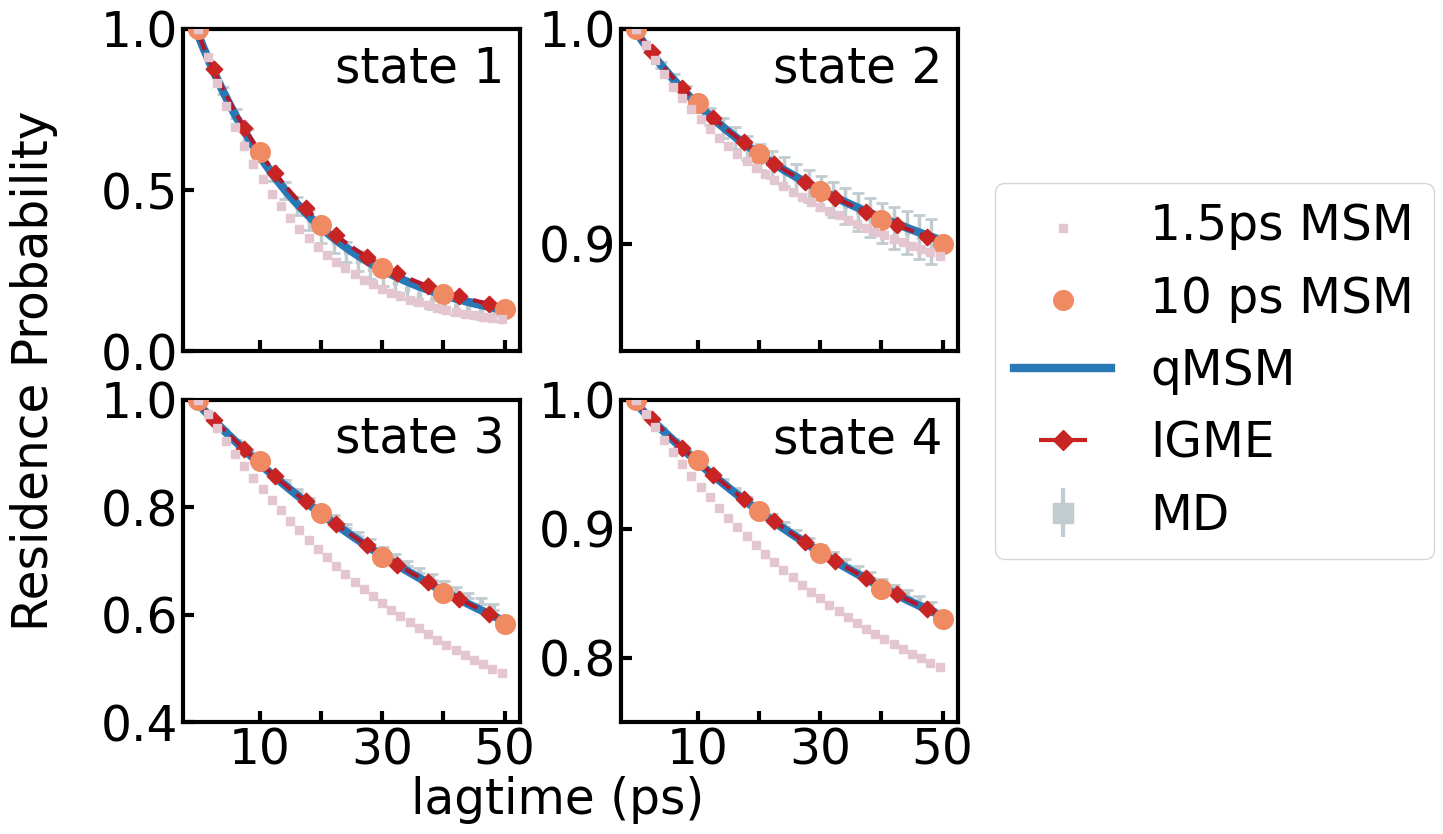

In [19]:
# @title CK test
length = 500
lt = np.arange(1,length+1) * delta_t
n_state = 4
plt.rcParams['font.size'] = 35
bottom = [0.02, 0.85, 0.4, 0.75]

TPM_mean = np.mean(bootstrap_TPM, axis=0)
TPM_std = np.std(bootstrap_TPM, axis=0)
fig, axes = plt.subplots(2,2,figsize=(10,9), sharex=True)

for i in range(n_state):
    ax = axes[i//2, i-(i//2)*2]
#     ax.fill_between(lt, TPM_mean[:length,i,i]-TPM_std[:length,i,i],
#                     TPM_mean[:length,i,i]+TPM_std[:length,i,i], color='#fff2df', zorder=0)
    ax.errorbar(x=lt[:length:20], y=TPM_mean[:length:20,i,i], yerr=TPM_std[:length:20,i,i],
                fmt='s', capsize=4, capthick=2, elinewidth=2.5, markersize=3,
                ecolor='#c2ccd0', color='#c2ccd0',
                zorder=0)
    ax.plot(qmsm_time[:length], qmsm_tpm[:length,i,i], color='#2878B5', linewidth=6, zorder=2)
    ax.plot(lt, igme_tpm[:length,i,i], color='#b2182b', linewidth=3, zorder=3, linestyle='--')
    ax.scatter(lt[24::50], igme_tpm[24:length:50,i,i], c='#C82423', marker='D', s=70, zorder=3)
    ax.scatter(msm_time_1, msm_tpm_1[:,i,i], c='#ef8a62', s=200, zorder=4)
    ax.scatter(msm_time_0, msm_tpm_0[:,i,i], c='#e4c6d0', s=40, marker='s', zorder=4)

    ax.set_ylim(bottom[i],1.0)
    ax.text(50, 0.95+0.05*bottom[i], 'state %d'%(i+1), ha='right',va='top')
    ax.tick_params(axis='both', direction='in', width=3, length=8)
    ax.set_xticks(ticks=[10,20,30,40,50], labels=[10,'',30,'',50])
    for spine in ax.spines.values():
        spine.set_linewidth(3)

axes[0, 0].set_ylim(0,1.0)
axes[0, 1].set_ylim(0.85,1.0)
axes[1, 0].set_ylim(0.4,1.0)
axes[1, 1].set_ylim(0.75,1.0)

plt.scatter([], [], c='#e4c6d0', s=40, marker='s', label='1.5ps MSM')
plt.scatter([], [], c='#ef8a62', s=200, label='10 ps MSM')
plt.plot([], [], label='qMSM', color='#2878B5', linewidth=6)
plt.errorbar([], [], xerr=[], color='#C82423', label='IGME', fmt='D',
             markersize=10, elinewidth=3, capsize=3)
plt.errorbar([], [], yerr=[], color='#c2ccd0', label='MD', fmt='s',
             markersize=15, elinewidth=3, capsize=3)
fig.text(0.5, 0.05, 'lagtime (ps)', ha='center', va='top')
fig.text(0, 0.5, "Residence Probability", ha='right', va='center', rotation=90)
fig.legend(loc='center right', bbox_to_anchor=(1.4, 0.5))
plt.subplots_adjust(wspace=0.3, hspace=0.15)
plt.show()

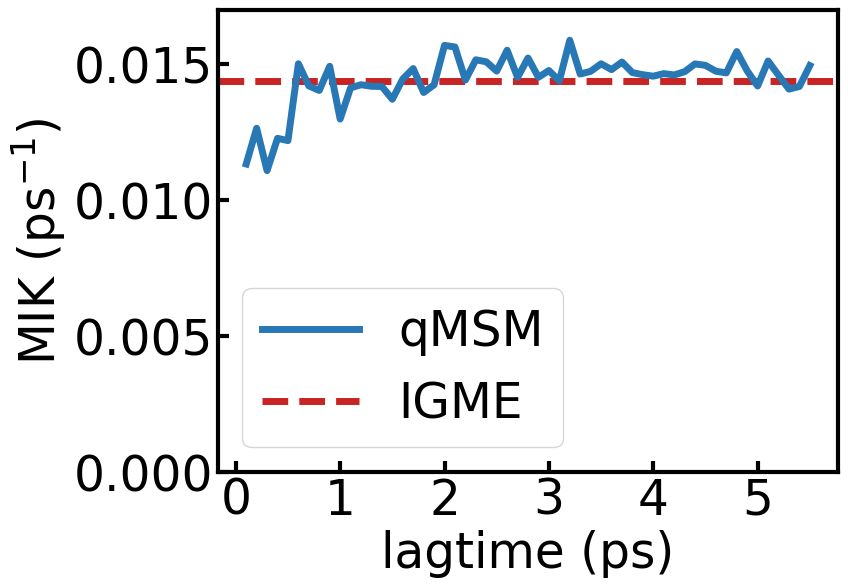

In [20]:
# @title MIK computed from qMSM and IGME
qmsm = QuasiMSM()
lagtime = np.arange(1, 56) * delta_t
qmsm.fit(TPM, tau_k=55, delta_t=delta_t, rmse=False)

# plot MIK
plt.rcParams['font.size'] = 35
fig, ax = plt.subplots(figsize=(8,6))
plt.axhline(y=igme_top.mik[1]/ delta_t, color='#C82423', linestyle='--', linewidth=5, zorder=0)
plt.plot(lagtime, qmsm.mik, color='#2878B5', linewidth=5, label='qMSM', zorder=1)
plt.plot([], [], color='#C82423', linewidth=5, label='IGME', linestyle='--',)
plt.ylim(0, 0.017)
plt.xlabel('lagtime (ps)')
plt.ylabel('MIK (ps$^{-1}$)')
ax.tick_params(axis='both', direction='in', width=3, length=8)
ax.set_xticks(ticks=[0,1,2,3,4,5])
for spine in ax.spines.values():
    spine.set_linewidth(3)
plt.legend()
plt.show()

In [21]:
# @title The timescales
print("Implied Timescales of 1.5 ps MSM:")
print(msm_0.timescales)

print("\nImplied Timescales of 10 ps MSM:")
print(msm_1.timescales)

print("\nImplied Timescales of qMSM at 100 ps:")
print(qmsm_its)

print("\nImplied Timescales of IGME:")
print(igme_its)

Implied Timescales of 1.5 ps MSM:
[1053.65197756   39.49202616   15.19822643]

Implied Timescales of 10 ps MSM:
[1131.7070932    56.77191266   19.14247057]

Implied Timescales of qMSM at 100 ps:
[1137.35416238   54.63913391   18.37283236]

Implied Timescales of IGME:
[1152.34228217   58.67294117   19.83555078]


In [22]:
# @title RMSE
print("RMSE of 1.5 ps MSM:")
print(msm_0.rmse)

print("\nRMSE of 10 ps MSM:")
print(msm_1.rmse)

print("\nRMSE of qMSM:")
print(qmsm_rmse[-1])

print("\nRMSE of IGME:")
print(igme_top_rmse)

RMSE of 1.5 ps MSM:
0.012185450387275518

RMSE of 10 ps MSM:
0.0019461125933943554

RMSE of qMSM:
0.0014813581427671136

RMSE of IGME:
0.0013669837363912165
